<a href="https://colab.research.google.com/github/ryyena/smart-load-balancer/blob/main/memoryAllocation_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score

**Importing dataset**

In [ ]:
dataset = pd.read_csv('/content/borg_traces_data.csv', engine='python')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset.head()

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0.000000e+00,2,9.459124e+10,3,1,200,0.000000e+00,144,1.688460e+11,...,0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,1,2.517310e+12,2,2.606980e+11,2,0,360,2.214950e+11,335,8.551509e+07,...,0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,2,1.956840e+11,6,2.762270e+11,2,0,103,0.000000e+00,376,1.693220e+11,...,0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,3,0.000000e+00,2,1.050739e+10,3,0,200,0.000000e+00,1977,1.782950e+11,...,0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1
4,4,1.810630e+12,3,2.591162e+10,2,0,0,0.000000e+00,3907,2.313650e+11,...,0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0


In [ ]:
dataset.shape

(405894, 34)

**Data preprocessing**

**Feature engineering**

In [ ]:
dataset['duration'] = dataset['end_time'] - dataset['start_time']

In [ ]:
# Convert strings to actual dictionaries
dataset['resource_request'] = dataset['resource_request'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now extract the values
dataset['cpu_resource_request'] = dataset['resource_request'].apply(
    lambda x: x.get('cpus') if isinstance(x, dict) else None
)

dataset['memory_resource_request'] = dataset['resource_request'].apply(
    lambda x: x.get('memory') if isinstance(x, dict) else None
)

In [ ]:
# Convert strings to actual dictionaries
dataset['average_usage'] = dataset['average_usage'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now extract the values
dataset['cpu_average_usage'] = dataset['average_usage'].apply(
    lambda x: x.get('cpus') if isinstance(x, dict) else None
)

dataset['memory_average_usage'] = dataset['average_usage'].apply(
    lambda x: x.get('memory') if isinstance(x, dict) else None
)


In [ ]:
pd.set_option('display.max_columns', None)
dataset.head()

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,resource_request,constraint,collections_events_type,user,collection_name,collection_logical_name,start_after_collection_ids,vertical_scaling,scheduler,start_time,end_time,average_usage,maximum_usage,random_sample_usage,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed,duration,cpu_resource_request,memory_resource_request,cpu_average_usage,memory_average_usage
0,0,0.000000e+00,2,9.459124e+10,3,1,200,0.000000e+00,144,1.688460e+11,"{'cpus': 0.020660400390625, 'memory': 0.014434...",[],2,fn8Ve4Tdl/FVVvwXFGIKe4+Wo4zLjUL/557qdFVYu5M=,Hzsv/gF8CPQXdqpsfovDTC1TJNyphDxPu7vaTeNxA74=,YCuhYrnORLiUh9WGL5q5tkBevfwtucSnFr2qPZh6Kes=,[],1.0,0.0,2.748000e+11,2.751000e+11,"{'cpus': 0.00466156005859375, 'memory': 0.0059...","{'cpus': 0.01190185546875, 'memory': 0.0059356...","{'cpus': 0.0043487548828125, 'memory': None}",0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1,300000000.0,0.020660,0.014435,0.004662,5.920410e-03
1,1,2.517310e+12,2,2.606980e+11,2,0,360,2.214950e+11,335,8.551509e+07,"{'cpus': 0.00724029541015625, 'memory': 0.0013...",[],2,DrrEIEWkWuW7RrZwpHLCN0k0A2J0usJeyt3wtqzZ7Kk=,hDGffcrF/rhQQEG8Uns/RMUK7R15DXjFnRasoKFhefI=,wcRcAMuop2OqH9EW4feH919tadFec5a11ply0hcS/C8=,[],2.0,0.0,1.800710e+12,1.800710e+12,"{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': 9.5367431640625e-07}","{'cpus': 0.0, 'memory': None}",0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1,0.0,0.007240,0.001303,0.000000,9.536743e-07
2,2,1.956840e+11,6,2.762270e+11,2,0,103,0.000000e+00,376,1.693220e+11,"{'cpus': 0.048583984375, 'memory': 0.004165649...",[],6,/ivQBmewiFcXfGJdCUsEKx47NiRE29Tjiq3gw+zR2Cg=,kk6+maA6fvAdJ+VTU8AcpzQPTyVrx+ySt0MXRAyO8FU=,zCA2dl2PDptd82Hob906gE82JHzx0SbqA4mZurqZdmY=,[],2.0,1.0,8.130000e+10,8.160000e+10,"{'cpus': 0.024200439453125, 'memory': 0.002788...","{'cpus': 0.06005859375, 'memory': 0.0028457641...","{'cpus': 0.026458740234375, 'memory': None}",0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0,300000000.0,0.048584,0.004166,0.024200,2.788544e-03
3,3,0.000000e+00,2,1.050739e+10,3,0,200,0.000000e+00,1977,1.782950e+11,"{'cpus': 0.0704345703125, 'memory': 0.04162597...",[],2,8qRmTJas/6XEBaA0l4Wt1+/qSLgc6p7u7JzoMSuT/M8=,fypwFjdqaQPSxCfeqVPCBAvFcnntmkRpQxwQ/vJsCxU=,uNjMQD1+DL9IgCFckx8lHOsCbyvLgKmZCmRjiyWZNhk=,[],2.0,0.0,1.075500e+12,1.075800e+12,"{'cpus': 0.047607421875, 'memory': 0.034423828...","{'cpus': 0.13330078125, 'memory': 0.03466796875}","{'cpus': 0.05084228515625, 'memory': None}",0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1,300000000.0,0.070435,0.041626,0.047607,3.442383e-02
4,4,1.810630e+12,3,2.591162e+10,2,0,0,0.000000e+00,3907,2.313650e+11,"{'cpus': 0.00244903564453125, 'memory': 0.0002...",[],3,+cz+wEXttqDjld+YWLmrgqExjdqiHMZ2WZODThyR9jE=,WS2kraTQdfsFtOIepw9SIo7ETi2ag8uwy7gt2MrpIe0=,VJ0ExwthLLpbqbyOA77EoNypzEiPYg3mECxUve0GCnY=,[],3.0,0.0,1.565320e+12,1.565320e+12,"{'cpus': 0.000270843505859375, 'memory': 7.629...","{'cpus': 0.00041484832763671875, 'memory': 7.6...","{'cpus': 0.0003414154052734375, 'memory': None}",0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0,0.0,0.002449,0.000232,0.000271,7.629395e-05


In [ ]:
dataset.shape

(405894, 39)

In [ ]:
dataset.head()
dataset.head()
dataset = dataset.drop([ 'collection_id','constraint','user','collection_name', 'resource_request','average_usage','maximum_usage', 'alloc_collection_id', 'instance_index', 'start_time', 'end_time', 'start_after_collection_ids', 'collection_logical_name', 'time', 'sample_rate', 'random_sample_usage','cpu_usage_distribution', 'tail_cpu_usage_distribution', 'machine_id', 'assigned_memory', 'page_cache_memory', 'cycles_per_instruction', 'memory_accesses_per_instruction'], axis=1)


In [ ]:
dataset.shape

(405894, 16)

In [ ]:
dataset.head()

,Unnamed: 0,instance_events_type,scheduling_class,collection_type,priority,collections_events_type,vertical_scaling,scheduler,cluster,event,failed,duration,cpu_resource_request,memory_resource_request,cpu_average_usage,memory_average_usage
0,0,2,3,1,200,2,1.0,0.0,7,FAIL,1,300000000.0,0.020660,0.014435,0.004662,5.920410e-03
1,1,2,2,0,360,2,2.0,0.0,7,FAIL,1,0.0,0.007240,0.001303,0.000000,9.536743e-07
2,2,6,2,0,103,6,2.0,1.0,7,SCHEDULE,0,300000000.0,0.048584,0.004166,0.024200,2.788544e-03
3,3,2,3,0,200,2,2.0,0.0,8,FAIL,1,300000000.0,0.070435,0.041626,0.047607,3.442383e-02
4,4,3,2,0,0,3,3.0,0.0,2,FINISH,0,0.0,0.002449,0.000232,0.000271,7.629395e-05


In [ ]:
dataset = dataset.drop(dataset.columns[[0]], axis=1)

**Handling missing values**

In [ ]:
dataset.isnull().sum()

,0
instance_events_type,0
scheduling_class,0
collection_type,0
priority,0
collections_events_type,0
vertical_scaling,959
scheduler,959
cluster,0
event,0
failed,0


In [ ]:
# Impute missing values with the most frequent value (mode) for each column
dataset['scheduler'].fillna(dataset['scheduler'].mode()[0], inplace=True)
dataset['vertical_scaling'].fillna(dataset['vertical_scaling'].mode()[0], inplace=True)



/tmp/ipython-input-1672505734.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['scheduler'].fillna(dataset['scheduler'].mode()[0], inplace=True)
/tmp/ipython-input-1672505734.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [ ]:
# Impute using median for skewed distributions
dataset['cpu_resource_request'].fillna(dataset['cpu_resource_request'].median(), inplace=True)
dataset['memory_resource_request'].fillna(dataset['memory_resource_request'].median(), inplace=True)


/tmp/ipython-input-3128009393.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['cpu_resource_request'].fillna(dataset['cpu_resource_request'].median(), inplace=True)
/tmp/ipython-input-3128009393.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [ ]:
dataset.isnull().sum()

,0
instance_events_type,0
scheduling_class,0
collection_type,0
priority,0
collections_events_type,0
vertical_scaling,0
scheduler,0
cluster,0
event,0
failed,0


**Encoding categorical data**

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['event'] = le.fit_transform(dataset['event'])


In [ ]:
dataset['event']

,event
0,2
1,2
2,7
3,2
4,3
...,...
405889,2
405890,0
405891,3
405892,2


**Handling skewed data and converting it into categories using binning**

In [ ]:
dataset['cpu_usage_log'] = np.log1p(dataset['cpu_average_usage'])
dataset['memory_usage_log'] = np.log1p(dataset['memory_average_usage'])

In [ ]:
labels = ['Very Very Low', 'Very Low', 'Low', 'Medium', 'High', 'Very High', 'Very Very High']

# Create categorical column for cpu_usage_log
dataset['cpu_usage_log_categorical'] = pd.qcut(
    dataset['cpu_usage_log'],  # transformed numeric column
    q=7,                       # number of bins
    labels=labels
)

# Create categorical column for memory_usage_log
dataset['memory_usage_log_categorical'] = pd.qcut(
    dataset['memory_usage_log'],  # transformed numeric column
    q=7,                       # number of bins
    labels=labels
)

In [ ]:
dataset['cpu_usage_log_categorical'].value_counts()

,count
cpu_usage_log_categorical,
Very Low,62129
Medium,58066
Very Very Low,58054
Very High,57910
Very Very High,57780
High,56226
Low,55729


In [ ]:
dataset['memory_usage_log_categorical'].value_counts()

,count
memory_usage_log_categorical,
Low,58690
Very High,58157
Very Very Low,58147
High,57987
Very Low,57899
Very Very High,57678
Medium,57336


In [ ]:
dataset.head()

,instance_events_type,scheduling_class,collection_type,priority,collections_events_type,vertical_scaling,scheduler,cluster,event,failed,duration,cpu_resource_request,memory_resource_request,cpu_average_usage,memory_average_usage,cpu_usage_log,memory_usage_log,cpu_usage_log_categorical,memory_usage_log_categorical
0,2,3,1,200,2,1.0,0.0,7,2,1,300000000.0,0.020660,0.014435,0.004662,5.920410e-03,0.004651,5.902953e-03,High,Very High
1,2,2,0,360,2,2.0,0.0,7,2,1,0.0,0.007240,0.001303,0.000000,9.536743e-07,0.000000,9.536739e-07,Very Very Low,Very Very Low
2,6,2,0,103,6,2.0,1.0,7,7,0,300000000.0,0.048584,0.004166,0.024200,2.788544e-03,0.023912,2.784663e-03,Very Very High,High
3,2,3,0,200,2,2.0,0.0,8,2,1,300000000.0,0.070435,0.041626,0.047607,3.442383e-02,0.046509,3.384458e-02,Very Very High,Very Very High
4,3,2,0,0,3,3.0,0.0,2,3,0,0.0,0.002449,0.000232,0.000271,7.629395e-05,0.000271,7.629104e-05,Low,Very Very Low


In [ ]:
dataset = dataset.drop(['cpu_average_usage', 'cpu_usage_log', 'memory_average_usage', 'memory_usage_log'], axis=1)

**Defining target and feature variables for load balancing**

In [ ]:
X = dataset.drop(columns=['cpu_usage_log_categorical','memory_usage_log_categorical'])
y = dataset[['cpu_usage_log_categorical','memory_usage_log_categorical']]

**Encoding target variable**

In [ ]:
encoder = LabelEncoder()
y_encoded_no = encoder.fit_transform(y['cpu_usage_log_categorical'])

print(y_encoded_no)            # integers
print(encoder.classes_)

[0 6 5 ... 5 3 3]
['High' 'Low' 'Medium' 'Very High' 'Very Low' 'Very Very High'
 'Very Very Low']


In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y['memory_usage_log_categorical'])

print(y_encoded)            # integers
print(encoder.classes_)

[3 6 0 ... 5 1 5]
['High' 'Low' 'Medium' 'Very High' 'Very Low' 'Very Very High'
 'Very Very Low']


**Splitting into train and test sets**

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


**Training XGBoost model**

In [ ]:
model = xgb.XGBClassifier(
    objective='multi:softprob',  # softprob gives probabilities
    num_class=len(set(y)),       # number of classes
    eval_metric='mlogloss',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=2, ...)

In [ ]:
y_pred = model.predict(X_test)

**Evaluation**

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9359932987595314


In [ ]:
print("Precision: ", precision_score(y_test, y_pred, average='macro'))

Precision:  0.9365957407104106


In [ ]:
print("Recall: ", recall_score(y_test, y_pred, average='macro'))

Recall:  0.9360793430586256


In [ ]:
print("F1 score: ", f1_score(y_test, y_pred, average='macro'))

F1 score:  0.936124934166231


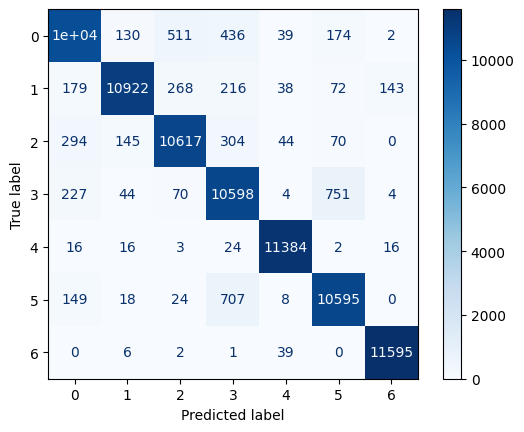

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

Text(0.5, 1.0, 'Precision, Recall, F1 per Class')

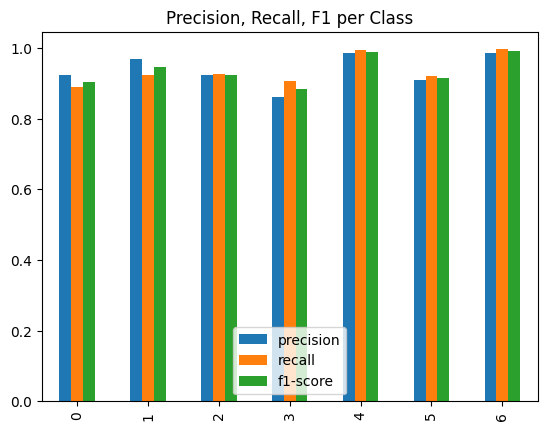

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.iloc[:-3, :-1].plot(kind='bar')
plt.title("Precision, Recall, F1 per Class")

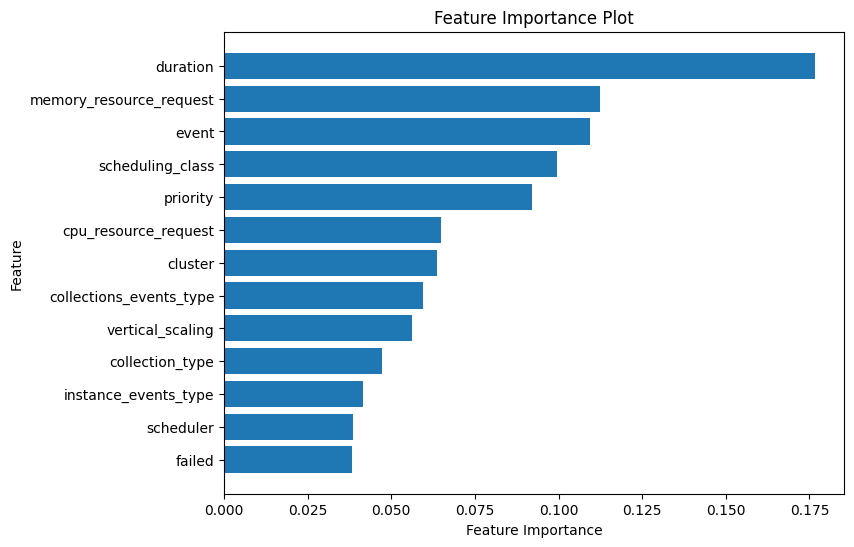

In [ ]:
importances = model.feature_importances_
features = X_train.columns  # If you have a DataFrame, else use range(len(importances))

# Sort features by importance
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Plot")
plt.show()